In [28]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, log_loss
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, accuracy_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
import sys
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification
sys.path.insert(0, '..') 

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Prepping the validation dataframe

In [3]:
from dataset import split_dataframe, JigsawDataset, load_glove_vocab

In [4]:
df = pd.read_csv('../data/train.csv')
_, val_df = split_dataframe(df)

d:\Work\Masters\Courses\[4] Natual Language Processing\Unintended Bias in Toxicity Classification\playground\..\dataset.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_toxic'] = df['target'] >= toxicity_threshold


In [5]:
labels = val_df['target'].tolist()

In [6]:
glove_vocab, glove_embeddings = load_glove_vocab('../data/glove.6B/glove.6B.100d.txt')

In [7]:
test_dataset = JigsawDataset(val_df['comment_text'], val_df['is_toxic'], glove_vocab, max_length=220)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

val_df['cleaned_comment'] = val_df['comment_text'].apply(clean_text)
Xtest_r2 = list(val_df['cleaned_comment'])
ytest_r2 = list(val_df['target'])

In [10]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

c:\Users\shrav\anaconda3\envs\NLP\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shrav\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [11]:
Xtest_encodings = tokenizer(Xtest_r2, truncation=True, padding=True, max_length=150, return_tensors='pt')

In [12]:
ytest_tensor = torch.tensor(ytest_r2, dtype=torch.float)
Xtesttorch = TensorDataset(Xtest_encodings['input_ids'], Xtest_encodings['attention_mask'], ytest_tensor)

NameError: name 'TensorDataset' is not defined

In [ ]:
test_dataloader = DataLoader(Xtesttorch, batch_size=1, shuffle=False)

### Getting LSTM predictions

In [ ]:
from model import ToxicityClassifierLSTM

In [ ]:
model = ToxicityClassifierLSTM(
        embedding_matrix=glove_embeddings,
        hidden_dim=128,
        output_dim=1,
        num_layers=2,
    )
model = model.to(DEVICE)
model.load_state_dict(torch.load('../checkpoints/LSTM_2.pth', weights_only=False, map_location=DEVICE))

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs).squeeze(1)
            all_preds.extend(predictions.int().cpu().numpy())
            all_labels.extend(labels.int().cpu().numpy())

    return all_preds, all_labels

In [ ]:
lstm_preds, binary_labels = predict(model, test_loader, DEVICE)

In [ ]:
lstm_binary_preds = [1 if pred >= 0.5 else 0 for pred in lstm_preds]

### Getting Roberta predictions

In [ ]:
roberta = RobertaForSequenceClassification.from_pretrained('../checkpoints', checkpoint_file='Roberta_1.pth')

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, attention_mask, labels in tqdm(test_loader):
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            predictions = roberta(inputs, attention_mask=attention_mask).logits.squeeze(0)
            # predictions = model(inputs).squeeze(1)
            # predictions = torch.tensor([pred[0] for pred in predictions]).to(device)
            
            all_preds.extend(sigmoid(predictions.detach().cpu().numpy()))
            all_labels.extend(labels.int().cpu().numpy())

    return all_preds, all_labels

### Ensemble Parameter Tuning

In [13]:
val_df = pd.read_csv('../data/val.csv')

In [15]:
lstm_preds = np.load('../checkpoints/lstm_preds.npy')
transformer_preds = np.load('../checkpoints/roberta_preds.npy')
labels = val_df['target'].tolist()

In [20]:
binary_lstm = [1 if pred >= 0.4 else 0 for pred in lstm_preds]
binary_transformer = [1 if pred >= 0.4 else 0 for pred in transformer_preds]
binary_labels = [1 if pred >= 0.4 else 0 for pred in labels]

In [23]:
def ensemble_loss(weights):
    x, y = weights
    ensemble_probs = x * lstm_preds + y * transformer_preds
    ensemble_probs = np.clip(ensemble_probs, 1e-7, 1 - 1e-7)  # Avoid numerical issues
    return log_loss(binary_labels, ensemble_probs)  # Binary cross-entropy

In [24]:
initial_weights = [0.5, 0.5]  # Start with equal weighting
constraints = ({'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1})  # Ensure x + y = 1
bounds = [(0, 1), (0, 1)]  # Weights must be between 0 and 1
result = minimize(ensemble_loss, initial_weights, bounds=bounds, constraints=constraints)
x_opt, y_opt = result.x

### Ensemble Results

In [27]:
ensemble_probs = x_opt * lstm_preds + y_opt * transformer_preds
ensemble_preds = (ensemble_probs > 0.4).astype(int)
accuracy = accuracy_score(binary_labels, ensemble_preds)
print(f"Ensemble Accuracy: {100*accuracy:.2f}%")

Ensemble Accuracy: 90.02%


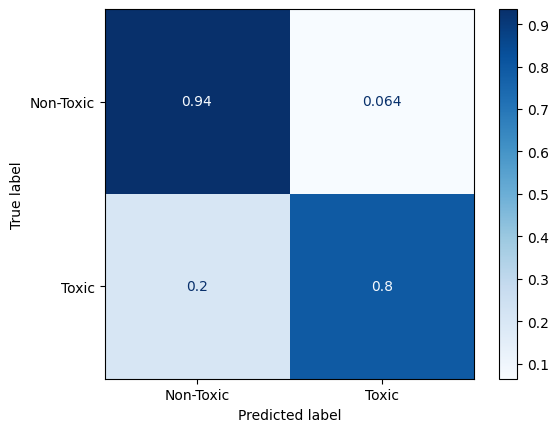

In [29]:
cm = confusion_matrix(binary_labels, ensemble_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap="Blues")

Precision: 0.87, Recall: 0.70


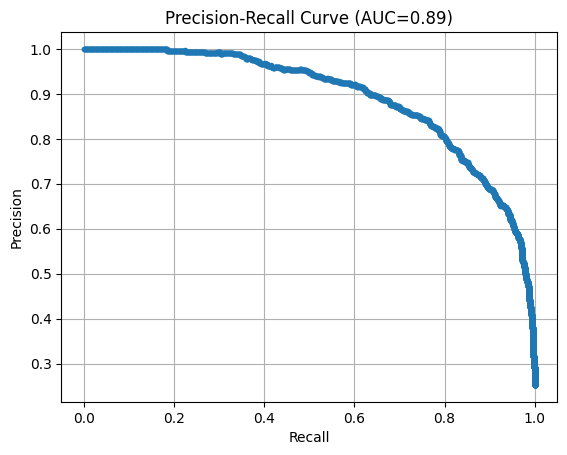

In [31]:
precision, recall, thresholds = precision_recall_curve(binary_labels, ensemble_probs)
pr_auc = auc(recall, precision)

threshold = 0.5
closest_idx = (np.abs(thresholds - threshold)).argmin()

precision_at_threshold = precision[closest_idx]
recall_at_threshold = recall[closest_idx]
print(f'Precision: {precision_at_threshold:0.2f}, Recall: {recall_at_threshold:0.2f}')

plt.plot(recall, precision, marker=".")
plt.title(f"Precision-Recall Curve (AUC={pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()